In [5]:
import numpy             as np
import matplotlib.pyplot as plt
import seaborn           as sns
import multiprocess      as mp
import pandas            as pd
import os

from libraries import utils

# For subscripts with normal font
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)

sns.set_theme()

Defining general output properties

In [6]:
linewidth     = 0.5
fontsize      = 8
eps_dpi       = 100
png_dpi       = 400
output_folder = 'output'
input_folder  = 'input'

Selecting a functional

In [126]:
functional = 'PS'
correction = ''

cmap = 'summer'

scale_factor  = 0.1
bar_name      = r'$\Delta H_f$ (eV/atom)'

Creating the grid

In [38]:
precision_search = 0.005

valid_xyz = None
x_grid = np.arange(-1, 1+precision_search, precision_search)

xyz_grid = []
for x in x_grid:
    for y in x_grid:
        xyz_grid.append([x, y])
xyz_grid = np.array(xyz_grid)

X, Y = np.meshgrid(x_grid, x_grid)

ERROR! Session/line number was not unique in database. History logging moved to new session 450


Generating data for the convex hull

In [113]:
x = 1 / 2
y = np.sqrt(3) / 2

pure_elements = {
    'Se':  [0, 0],
    'Sb': [1, 0],
    'I':  [x, y]
}

pure_phases = [
    'SbSeI'
]

secondary_phases = [
    'Sb2Se3',
    'SbI3'
]

phases_text = [
    r'$Sb_2Se_3$',
    r'$SbI_3$'
]

Showing the results

In [114]:
def parallelize_energy_calculation(composition_idx):
    """Expects formation energies for both pure compounds and predicted mixtures.
    """
    
    a, b = xyz_grid[composition_idx]
    test_r = [a, b]

    n_elements = len(elements)
    possible_triangles = []

    # Iterating over every possible triangle without repetition

    for i in np.arange(n_elements):
        for j in np.arange(i+1, n_elements):
            for k in np.arange(j+1, n_elements):
                element_i = elements[i]
                element_j = elements[j]
                element_k = elements[k]
                
                # Only triangles containing the test element are considered

                if utils.is_in_triangle(elements, coordinates,
                                       element_i, element_j, element_k, test_r):
                    # The expected energy is computed

                    expected_energy = utils.get_expected_energy(energies, elements, coordinates,
                                                               element_i, element_j, element_k, test_r)

                    # The information is appended

                    possible_triangles.append([element_i, element_j, element_k, expected_energy])

    # Converting information into array
    
    possible_triangles = np.array(possible_triangles)
    
    # Extracting the computed and minimal expected formation energies
    
    if len(possible_triangles):
        expected_formation_energy = np.min(np.array(possible_triangles[:, 3], dtype=float))
        return a, b, expected_formation_energy
    return a, b, np.NaN

Energy calculations, if required

In [115]:
# Defining the flag for the energy

flag = functional
if len(correction):
    flag = f'{functional}_{correction}'

# Loading the ground-state energies

with open('../Secondary/Input/chemical_potentials.txt', 'r') as file:
    lines = file.readlines()

# Loading the data into a DataFrame

energies = []
for line in lines:
    energies.append(line.split())

energies = pd.DataFrame(energies)
new_header = energies.iloc[0]
energies = energies[1:]
energies.columns = new_header# Selecting only the functional we are interested in

total_energy_flag = f'total_energy_{flag}'
energies = energies[['element', 'nfu', total_energy_flag]]

# Convering nfu and energy to numeric

energies['nfu']             = energies['nfu'].apply(pd.to_numeric)
energies[total_energy_flag] = energies[total_energy_flag].apply(pd.to_numeric)

# Getting energy by formula unit

energies['energy'] = energies[total_energy_flag] / energies['nfu']
energies = energies.set_index('element', drop=True)

# Generating formation energy

energies['formation_energy'] = energies['energy']
for index in energies.index:
    if index is not None:
        composition, concentration = utils.composition_concentration(index)

        composition   = composition.split()
        concentration = np.array(concentration.split(), dtype=int)

        formation_energy = energies.loc[index].energy
        natoms = 0
        for i in range(len(composition)):
            formation_energy -= concentration[i] * energies.loc[composition[i]].energy
            natoms += concentration[i]
        
        energies.formation_energy.loc[index] = formation_energy / natoms  # In eV/atom

# Getting positional data for hexagon

data = []

# Appending the pure elements

for element in pure_elements:
    a = pure_elements[element][0]
    b = pure_elements[element][1]
    data.append([a, b, element])

# Appending the pure phases

for element in pure_phases:
    composition, concentration = utils.composition_concentration(element)
    a, b = utils.get_ab(pure_elements, composition, concentration)
    data.append([a, b, element])

# Appending the secondary phases

for element in secondary_phases:
    composition, concentration = utils.composition_concentration(element)
    a, b = utils.get_ab(pure_elements, composition, concentration)
    data.append([a, b, element])

# Getting the arrays with information of names and corresponding coordinates

data        = np.array(data)
coordinates = np.array(data[:, :2], dtype=float)
elements    = data[:, 2]

if os.path.exists(f'{input_folder}/temporal_surface.txt'):
    results = np.loadtxt(f'{input_folder}/temporal_surface.txt')
else:
    # Parallelizing calculations

    pool    = mp.Pool(mp.cpu_count())
    results = [pool.apply(parallelize_energy_calculation, (index,)) for index in range(len(xyz_grid))]
    pool.close()

    results = np.array(results, dtype=float)
    #np.savetxt(f'{input_folder}/temporal_surface.txt', results)

xyz_grid = results[:, :2]
xyz_pred = results[:, 2]

# Changing to 2D representation

n = len(x_grid)
Z = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        Z[j, i] = xyz_pred[i*n + j]

# Projection plot

0.5 0.28867513459481287 SbSeI
0.4 0.0 Sb2Se3
0.625 0.649519052838329 SbI3


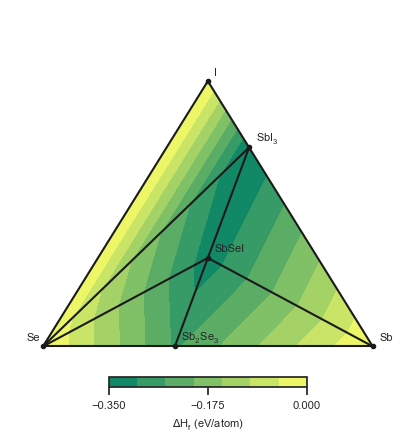

In [147]:
sns.set_theme(style='white')
fig = plt.figure(figsize=DL.get_figsize(1.5, 1.1))

# Displacement for text

dt = 2e-2

# Plotting the computed convex-hull energies

sc = plt.contourf(X, Y, Z, cmap=cmap)

# Plotting the pure elements

element = 'Se'
a = pure_elements[element][0]
b = pure_elements[element][1]
energy = energies.loc[element].formation_energy
plt.plot(a, b, '.k')
plt.text(a-5e-2, b+dt, element,
       fontsize=fontsize)

element = 'Sb'
a = pure_elements[element][0]
b = pure_elements[element][1]
energy = energies.loc[element].formation_energy
plt.plot(a, b, '.k')
plt.text(a+dt, b+dt, element,
       fontsize=fontsize)

element = 'I'
a = pure_elements[element][0]
b = pure_elements[element][1]
energy = energies.loc[element].formation_energy
plt.plot(a, b, '.k')
plt.text(a+dt, b+dt, element,
       fontsize=fontsize)

# Plotting the pure phases

for element in pure_phases:
    [composition, concentration] = utils.composition_concentration(element)
    a, b = utils.get_ab(pure_elements, composition, concentration)
    energy = energies.loc[element].formation_energy
    plt.plot(a, b, '.k')
    plt.text(a+dt, b+dt, element,
           fontsize=fontsize)
    print(a, b, element)

# Plotting the secondary phases

for i in range(len(secondary_phases)):
    element = secondary_phases[i]
    [composition, concentration] = utils.composition_concentration(element)
    a, b = utils.get_ab(pure_elements, composition, concentration)
    energy = energies.loc[element].formation_energy
    plt.plot(a, b, '.k')
    plt.text(a+dt, b+dt, phases_text[i],
           fontsize=fontsize)
    print(a, b, element)

# Setting minimum and maximum values for the colorbar

Z_dropped_nan = Z[~np.isnan(Z)]

vmin = np.floor(np.min(Z_dropped_nan) / scale_factor) * scale_factor
vmax = np.ceil(np.max(Z_dropped_nan)  / scale_factor) * scale_factor

# Bar

cbar = plt.colorbar(sc, orientation='horizontal', location='bottom',
                    pad=0, shrink=0.5, ticks=np.linspace(-0.35, vmax, 3))

# Defining bar

cbar.ax.tick_params(labelsize=fontsize)
cbar.set_label(bar_name, fontsize=fontsize)


linewidth = 1.5
plt.plot([0, 1], [0, 0], 'k', linewidth=linewidth)
plt.plot([1, x], [0, y], 'k', linewidth=linewidth)
plt.plot([0, x], [0, y], 'k', linewidth=linewidth)
plt.plot([0, 0.5], [0, 0.28867513459481287], 'k', linewidth=linewidth)
plt.plot([1, 0.5], [0, 0.28867513459481287], 'k', linewidth=linewidth)
plt.plot([0.625, 0], [0.649519052838329, 0], 'k', linewidth=linewidth)
plt.plot([0.4, 0.5], [0, 0.28867513459481287], 'k', linewidth=linewidth)
plt.plot([0.625, 0.5], [0.649519052838329, 0.28867513459481287], 'k', linewidth=linewidth)

dt = 1e-1
plt.xlim(0-dt, 1+dt)
plt.ylim(0-dt, 1+dt)
plt.axis('off')
plt.savefig(f'{output_folder}/Projection_stability.eps', dpi=eps_dpi, bbox_inches='tight')
plt.show()

0.5 0.28867513459481287 SbSeI
0.4 0.0 Sb2Se3
0.625 0.649519052838329 SbI3


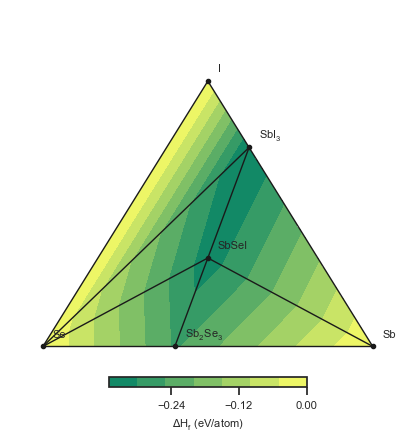

In [138]:
sns.set_theme(style='white')
fig = plt.figure(figsize=DL.get_figsize(1.5, 1.1))

# Displacement for text

dt = 3e-2

# Plotting the computed convex-hull energies

sc = plt.contourf(X, Y, Z, cmap=cmap)

# Plotting the pure elements

for element in pure_elements:
    a = pure_elements[element][0]
    b = pure_elements[element][1]
    energy = energies.loc[element].formation_energy
    plt.plot(a, b, '.k')
    plt.text(a+dt, b+dt, element,
           fontsize=fontsize)

# Plotting the pure phases

for element in pure_phases:
    [composition, concentration] = utils.composition_concentration(element)
    a, b = utils.get_ab(pure_elements, composition, concentration)
    energy = energies.loc[element].formation_energy
    plt.plot(a, b, '.k')
    plt.text(a+dt, b+dt, element,
           fontsize=fontsize)
    print(a, b, element)

# Plotting the secondary phases

for i in range(len(secondary_phases)):
    element = secondary_phases[i]
    [composition, concentration] = utils.composition_concentration(element)
    a, b = utils.get_ab(pure_elements, composition, concentration)
    energy = energies.loc[element].formation_energy
    plt.plot(a, b, '.k')
    plt.text(a+dt, b+dt, phases_text[i],
           fontsize=fontsize)
    print(a, b, element)

# Setting minimum and maximum values for the colorbar

Z_dropped_nan = Z[~np.isnan(Z)]

vmin = np.floor(np.min(Z_dropped_nan) / scale_factor) * scale_factor
vmax = np.ceil(np.max(Z_dropped_nan)  / scale_factor) * scale_factor

# Bar

cbar = plt.colorbar(sc, orientation='horizontal', location='bottom',
                    pad=0, shrink=0.5, ticks=np.linspace(-0.48, vmax, 5))

# Defining bar

cbar.ax.tick_params(labelsize=fontsize)
cbar.set_label(bar_name, fontsize=fontsize)


linewidth = 1
plt.plot([0, 1], [0, 0], 'k', linewidth=linewidth)
plt.plot([1, x], [0, y], 'k', linewidth=linewidth)
plt.plot([0, x], [0, y], 'k', linewidth=linewidth)
plt.plot([0, 0.5], [0, 0.28867513459481287], 'k', linewidth=linewidth)
plt.plot([1, 0.5], [0, 0.28867513459481287], 'k', linewidth=linewidth)
plt.plot([0.625, 0], [0.649519052838329, 0], 'k', linewidth=linewidth)
plt.plot([0.4, 0.5], [0, 0.28867513459481287], 'k', linewidth=linewidth)
plt.plot([0.625, 0.5], [0.649519052838329, 0.28867513459481287], 'k', linewidth=linewidth)

dt = 1e-1
plt.xlim(0-dt, 1+dt)
plt.ylim(0-dt, 1+dt)
plt.axis('off')
plt.savefig(f'{output_folder}/Projection_stability.eps', dpi=eps_dpi, bbox_inches='tight')
plt.show()

In [112]:
element = 'BiSeBr'
element0 = 'Bi2Se3'
element1 = 'BiBr3'

pure_elements = {
    'Se':  [0, 0],
    'Bi': [1, 0],
    'Br':  [x, y]
}

[composition, concentration] = utils.composition_concentration(element)
a, b = utils.get_ab(pure_elements, composition, concentration)
energy = energies.loc[element].formation_energy

[composition, concentration] = utils.composition_concentration(element0)
a0, b0 = utils.get_ab(pure_elements, composition, concentration)
energy0 = energies.loc[element0].formation_energy

[composition, concentration] = utils.composition_concentration(element1)
a1, b1 = utils.get_ab(pure_elements, composition, concentration)
energy1 = energies.loc[element1].formation_energy

d1 = np.linalg.norm(np.array([a, b]) - np.array([a0, b0]))
d2 = np.linalg.norm(np.array([a, b]) - np.array([a1, b1]))
aux = d1 + d2

a1 = energies.loc[element0]['formation_energy']
a2 = (energies.loc[element1]['formation_energy'] - energies.loc[element0]['formation_energy']) * d1 / aux
energy - (a1 + a2)

-0.005430564814814853